# Batch analysis across mice & regions

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

## Imports

In [2]:
import logging
from constants import *
from utils import *
from logger import logger
from fileops import get_stats_dir, get_traces_dir, get_figs_dir, load_mousereg_datasets, save_figs_book
from postpro import *
from plotters import *
logger.setLevel(logging.INFO)
figs = {}

### Parameters

In [3]:
# Whether to perform averages weighted buy the respective number of ROIs in each dataset 
weighted = False

### Load data

In [4]:
logger.info('loading stats:')
Fstats = load_mousereg_datasets(get_stats_dir())
# Get the dimensions of the dataset dataset
mouseregs = Fstats.index.unique(level=Label.MOUSEREG).values
runs = Fstats.index.unique(level=Label.RUN).values
# Show dataset
Fstats

 06/05/2022 13:40:21: loading stats:
 06/05/2022 13:40:21: loading data from mouse1_region1.csv
 06/05/2022 13:40:21: loading data from mouse1_region2.csv
 06/05/2022 13:40:21: loading data from mouse6_region1.csv
 06/05/2022 13:40:21: loading data from mouse6_region2.csv
 06/05/2022 13:40:21: loading data from mouse7_region1.csv
 06/05/2022 13:40:21: loading data from mouse7_region2.csv
 06/05/2022 13:40:21: loading data from mouse9_region1.csv
 06/05/2022 13:40:21: loading data from mouse9_region2.csv
 06/05/2022 13:40:21: loading data from mouse10_region1.csv
 06/05/2022 13:40:21: loading data from mouse12_region1.csv


line  trial_length  duration (s)   fps  run ID  \
mouse_reg       ROI run                                                    
mouse1_region1  1   0    line3         100.0           0.2  3.56   727.0   
                    1    line3         100.0           0.2  3.56   725.0   
                    2    line3         100.0           0.2  3.56   724.0   
                    3    line3         100.0           0.2  3.56   723.0   
                    4    line3         100.0           0.2  3.56   726.0   
...                        ...           ...           ...   ...     ...   
mouse12_region1 882 10   line3         100.0           0.2  3.56   856.0   
                    11   line3         100.0           0.2  3.56   855.0   
                    12   line3         100.0           0.2  3.56   861.0   
                    13   line3         100.0           0.2  3.56   862.0   
                    14   line3         100.0           0.2  3.56   863.0   

                         P (MPa)  DC (%)  I_SPPA (W/cm2)  I_SPTA (W/cm2)  \
mouse_reg       ROI run                                                    
mouse1_region1  1   0       0.00    50.0        0.000000        0.000000   
                    1       0.10    50.0        0.309132        0.154566   
                    2       0.20    50.0        1.236530        0.618265   
                    3       0.40    50.0        4.946119        2.473059   
                    4       0.05    50.0        0.077283        0.038642   
...                          ...     ...             ...             ...   
mouse12_region1 882 10      0.80    40.0       19.784475        7.913790   
                    11      0.80    50.0       19.784475        9.892238   
                    12      0.80    60.0       19.784475       11.870685   
                    13      0.80    70.0       19.784475       13.849133   
                    14      0.80    80.0       19.784475       15.827580   

                         success rate  Z(success rate)  positive condition?  \
mouse_reg       ROI run                                                       
mouse1_region1  1   0        0.100000        -5.384534                  0.0   
                    1        0.250000        -0.129241                  0.0   
                    2        0.000000        -8.888062                  0.0   
                    3        0.142857        -3.883022                  0.0   
                    4        0.000000        -8.888062                  0.0   
...                               ...              ...                  ...   
mouse12_region1 882 10       0.000000        -7.893374                  0.0   
                    11       0.300000        19.856769                  1.0   
                    12       0.545455        42.561431                  1.0   
                    13       0.461538        34.799153                  1.0   
                    14       0.166667         7.523372                  1.0   

                         # positive conditions  responsive ROI?  \
mouse_reg       ROI run                                           
mouse1_region1  1   0                      3.0              0.0   
                    1                      3.0              0.0   
                    2                      3.0              0.0   
                    3                      3.0              0.0   
                    4                      3.0              0.0   
...                                        ...              ...   
mouse12_region1 882 10                     9.0              1.0   
                    11                     9.0              1.0   
                    12                     9.0              1.0   
                    13                     9.0              1.0   
                    14                     9.0              1.0   

                          response type  \
mouse_reg       ROI run                   
mouse1_region1  1   0    non-responsive   
                   

### Cell type breakdown

 06/05/2022 13:40:21: 50.0% overall resonsiveness achieved with a threshold of 6.9 positive conditions


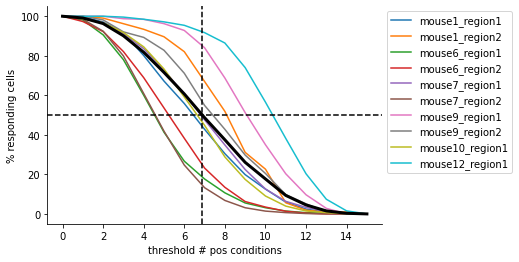

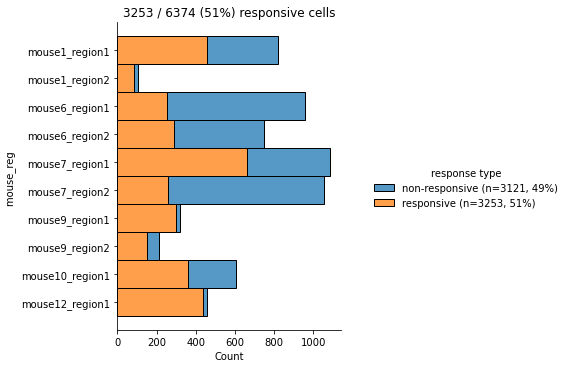

In [5]:
# Compute % responsive cells as a function of nposthr
nposthrs = np.arange(runs.max() + 2)
pctresps = {k: np.zeros(nposthrs.size) for k in mouseregs}
nresps_overall = np.zeros(nposthrs.size)
for i, nposthr in enumerate(nposthrs):
    isresproi = reclassify(Fstats.copy(), nposthr=nposthr)[Label.IS_RESP_ROI].groupby(
        [Label.MOUSEREG, Label.ROI]).first()
    for k, group in isresproi.groupby(Label.MOUSEREG):
        nresps = group.sum()
        pctresps[k][i] = nresps / len(group) * 100
        nresps_overall[i] += nresps
pctresps = pd.DataFrame(pctresps)
if weighted:
    pctresps_avg = nresps_overall / len(isresproi) * 100
else:
    pctresps_avg = pctresps.mean(axis=1)
pctresp_critical = 50.
nposthr_critical = np.interp(-pctresp_critical, -pctresps_avg, nposthrs)
nposthr = np.round(nposthr_critical)
logger.info(f'{pctresp_critical}% overall resonsiveness achieved with a threshold of {nposthr_critical:.1f} positive conditions')

# Plot % responsive cells as a function of nposthr
figs['pctresp_vs_nposthr'], ax = plt.subplots()
ax.set_xlabel('threshold # pos conditions')
ax.set_ylabel('% responding cells')
for k, v in pctresps.items():
    ax.plot(nposthrs, v, label=k)
ax.plot(nposthrs, pctresps_avg, 'k', lw=3)
ax.axhline(pctresp_critical, ls='--', c='k')
ax.axvline(nposthr_critical, ls='--', c='k')
sns.despine(ax=ax)
ax.legend(bbox_to_anchor=(1.0, 1.0))

# Plot classification for default nposthr
figs['rtype_dist_per_mousereg'] = plot_cellcounts_by_type(Fstats, hue=Label.ROI_RESP_TYPE)

### Ouput metrics as a function of threshold # pos conditions

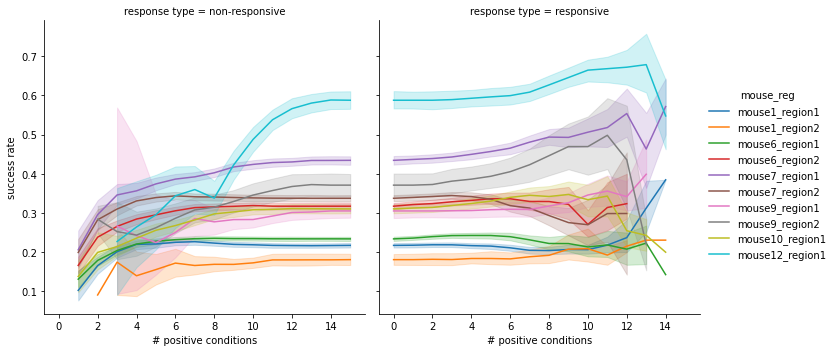

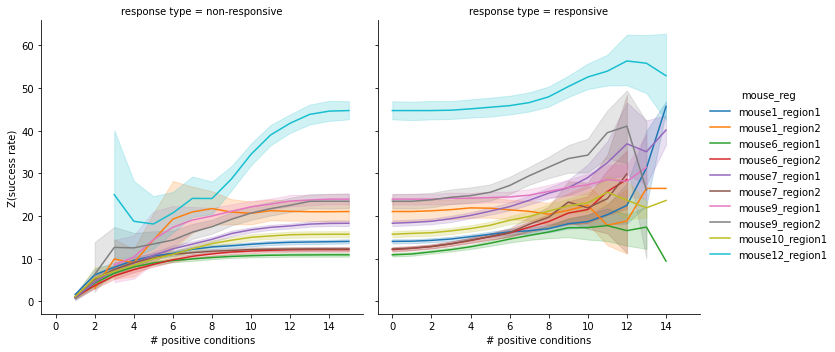

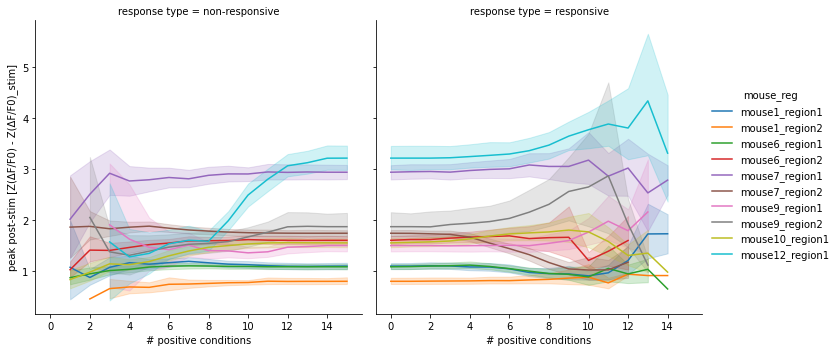

In [6]:
# Compute max metrics per cell type as a function of nposthr
ykeys = [Label.SUCCESS_RATE, Label.ZSCORED_SUCCESS_RATE, Label.PEAK_REL_ZSCORE_POSTSTIM]
metrics_vs_nposthr = compute_metrics_vs_nposthr(Fstats, nposthrs, ykeys)

# Plot metrics per dataset and response type as a function of nposthr
for ykey in ykeys:
    figs[f' max {ykey} vs nposthr'] = sns.relplot(
        data=metrics_vs_nposthr,
        kind='line',
        x=Label.NPOS_CONDS,
        y=ykey,
        hue=Label.MOUSEREG,
        hue_order=mouseregs,
        col=Label.ROI_RESP_TYPE, 
        col_order=get_default_rtypes()
    ).figure

 06/05/2022 13:47:37: selected 95610 / 95610 samples (100.0% of dataset)
 06/05/2022 13:47:37: sub-indexing data...
 06/05/2022 13:47:37: filtering data...
 06/05/2022 13:47:37: cross-checking filters...
 06/05/2022 13:47:37: grouping by response type, grouping by mouse_reg, averaging, estimating confidence intervals and plotting mean success rate vs. P (MPa) ...
 06/05/2022 13:47:40: selected 95610 / 95610 samples (100.0% of dataset)
 06/05/2022 13:47:40: sub-indexing data...
 06/05/2022 13:47:40: filtering data...
 06/05/2022 13:47:40: cross-checking filters...
 06/05/2022 13:47:40: grouping by response type, grouping by mouse_reg, averaging, estimating confidence intervals and plotting mean Z(success rate) vs. P (MPa) ...
 06/05/2022 13:47:42: selected 95610 / 95610 samples (100.0% of dataset)
 06/05/2022 13:47:43: sub-indexing data...
 06/05/2022 13:47:43: filtering data...
 06/05/2022 13:47:43: cross-checking filters...
 06/05/2022 13:47:43: grouping by response type, grouping by 

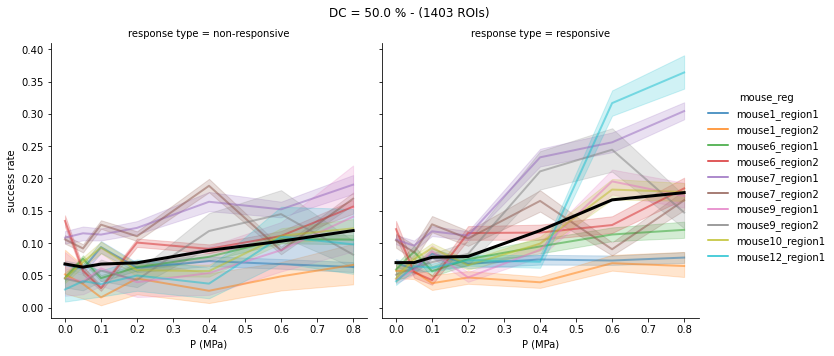

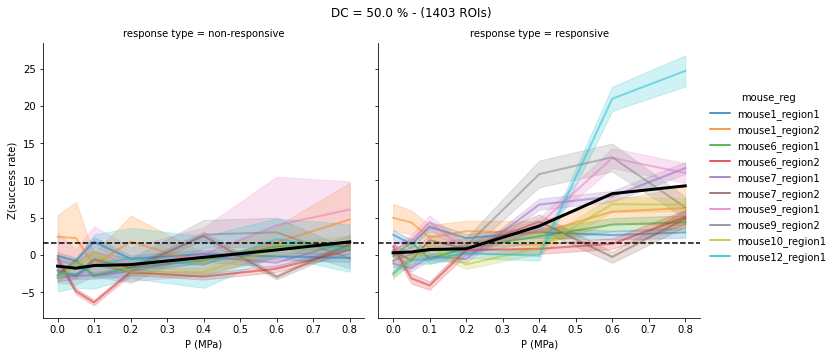

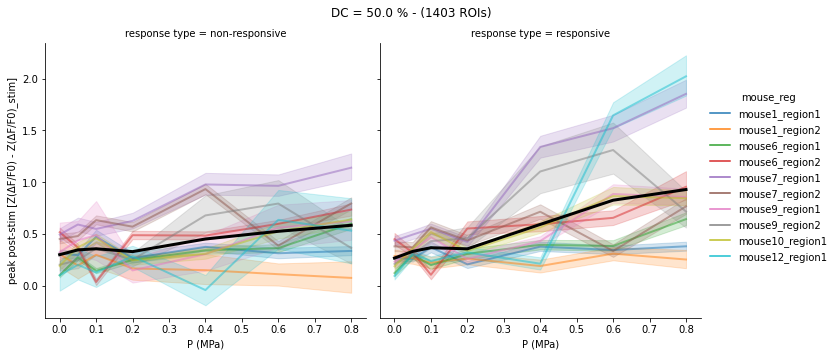

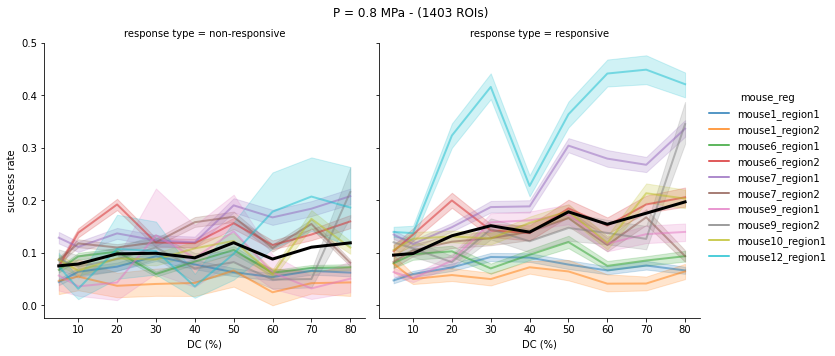

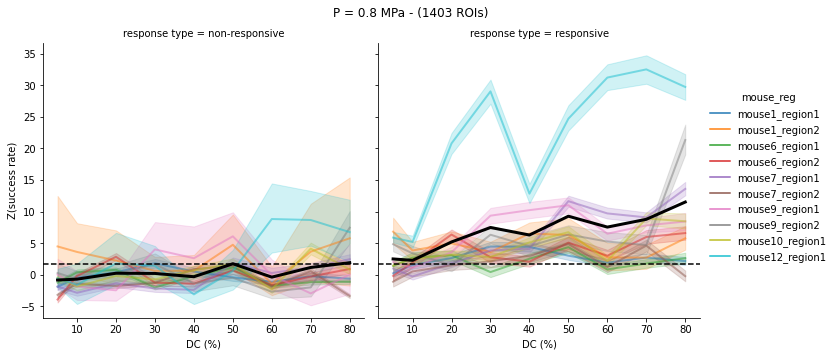

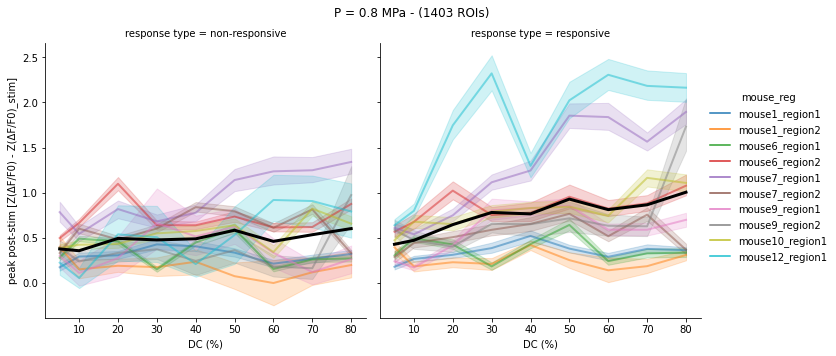

In [9]:
xkeys = [
    Label.P,
    Label.DC,
]
ykeys = [
    Label.SUCCESS_RATE,
    Label.ZSCORED_SUCCESS_RATE,
    Label.PEAK_REL_ZSCORE_POSTSTIM
]
zthr = pvalue_to_zscore(.05)  # 1-sided

for xkey in xkeys:
    for ykey in ykeys:
        figs[f'{ykey}_vs_{xkey}'] = plot_parameter_dependency_across_datasets(
            Fstats, xkey, ykey,
            baseline=zthr if ykey == Label.ZSCORED_SUCCESS_RATE else None)

### Save figures

In [10]:
figsdir = get_figs_dir()  # Directory for output figures
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, prefix='global')

 06/05/2022 13:48:10: saving figure "pctresp_vs_nposthr" on page 0
 06/05/2022 13:48:10: saving figure "rtype_dist_per_mousereg" on page 1
 06/05/2022 13:48:10: saving figure " max success rate vs nposthr" on page 2
 06/05/2022 13:48:10: saving figure " max Z(success rate) vs nposthr" on page 3
 06/05/2022 13:48:10: saving figure " max peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] vs nposthr" on page 4
 06/05/2022 13:48:10: saving figure "success rate_vs_P (MPa)" on page 5
 06/05/2022 13:48:10: saving figure "Z(success rate)_vs_P (MPa)" on page 6
 06/05/2022 13:48:10: saving figure "peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim]_vs_P (MPa)" on page 7
 06/05/2022 13:48:11: saving figure "success rate_vs_DC (%)" on page 8
 06/05/2022 13:48:11: saving figure "Z(success rate)_vs_DC (%)" on page 9
 06/05/2022 13:48:11: saving figure "peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim]_vs_DC (%)" on page 10
